<div dir=rtl><h1>
&emsp;
&emsp;
&emsp;
&emsp;
&emsp;
<b>
פרוייקט חלק 5 ב'
</b>
</h1>

<h4>
שמות: אריאל נובומינסקי, אילי ששון
</br>
ת.ז. : 322228974, 322995358
</h4>


</div>

<div dir=rtl>
<h4>
בחלק זה, נסתכל על המשתנים המסבירים Installs, Recently Updated, Reviews ו - IsFree ועל המשנה המוסבר Rating.

נטען את סט הנתונים ונבצע את הטרנספורמציות שביצענו בחלקים הקודם:
</h4>


</div>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from scipy.stats import beta
from scipy.stats import bernoulli
import scipy as scs
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from tabulate import tabulate
from scipy.linalg import fractional_matrix_power
from sklearn.metrics import log_loss
import math
from scipy.stats import norm

In [2]:
df = pd.read_csv("/content/googleplaystore.csv")
df = df.drop(df[(df.Type !='Paid') & (df.Type !='Free')].index)
df = df.dropna()
isFree_Data = df.Type.apply(lambda x: True if x=='Free' else False)
df.insert(7,'IsFree',isFree_Data)
df = df.drop('Type', 1)
df['Last Updated'] = df['Last Updated'].str.replace(',', '')
Last_Updated=pd.to_datetime(df['Last Updated'], format='%B %d %Y')
df = df.drop('Last Updated',axis=1)
df.insert(9,'Last Updated',Last_Updated)
recntly = df['Last Updated'].map(lambda x: True if x > datetime.date(2018,6,1) else False)
df.insert(9,'Recntly Updated',recntly)
df['Installs'] = df['Installs'].map(lambda s: int(s[:-1].replace(',', '')))
df = df[df['Size'] !='Varies with device']
df['Size'] = df['Size'].map(lambda x: float(x.split('k')[0]) if 'k' in x else float(x.split('M')[0])*1024 )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  # This is added back by InteractiveShellApp.init_path()


In [3]:
df.head()

,App,Category,Rating,Reviews,Size,Installs,IsFree,Price,Content Rating,Recntly Updated,Last Updated,Genres,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19456.0,10000,True,0,Everyone,False,2018-01-07,Art & Design,1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14336.0,500000,True,0,Everyone,False,2018-01-15,Art & Design;Pretend Play,2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8908.8,5000000,True,0,Everyone,True,2018-08-01,Art & Design,1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25600.0,50000000,True,0,Teen,True,2018-06-08,Art & Design,Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2867.2,100000,True,0,Everyone,True,2018-06-20,Art & Design;Creativity,1.1,4.4 and up


In [4]:
data_df = df[['Rating', 'Recntly Updated', 'Installs', 'IsFree', 'Reviews']].copy()
data_df['Recntly Updated'] = data_df['Recntly Updated'].map(lambda x: 1 if x else 0) 

<div dir=rtl>
<h4>
1. נבחר תת מדגם באופן אקראי בגודל 1000:
</h4>
</div>

In [5]:
sample = data_df.sample(1000, random_state=1)
sample.head(5)

,Rating,Recntly Updated,Installs,IsFree,Reviews
10201,4.0,0,100000,True,710
3415,4.1,0,1000000,True,12180
7036,4.4,1,100000,True,8433
4950,4.1,0,1000000,True,14491
455,4.6,1,1000000,True,183374


<div dir=rtl>
<h4>
נזכר בהתפלגות הדירוגים באמצעות היסטוגרמה: 
</h4>
</div>

Rating Mean:  4.188999999999997
Rating Median:  4.3
Rating Variance:  0.279019000000001


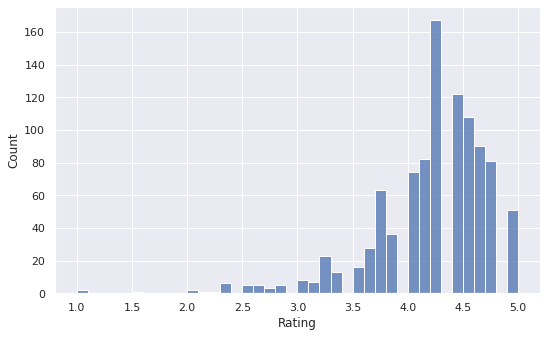

In [6]:
sns.set(rc={'figure.figsize':(8.7,5.27)})

sns.histplot(sample['Rating'])

print('Rating Mean: ', np.mean(sample['Rating']))
print('Rating Median: ', np.median(sample['Rating']))
print('Rating Variance: ', np.var(sample['Rating']))

<div dir=rtl>
<h4>
כפי שציינו בחלקים קודמים, ההתפלגות היא התפלגות נורמלית עם זנב שמאלי כבד כאשר מרבית האפליקציות מקבלות דירוגים "גבוהים" (מעל 4).
<br>
בנוסף, נשים לב כי השונות היא יחסית קטנה (~0.28).
</h4>
</div>

<div dir=rtl>
<h4>
2.
נרצה לבצע רגרסיה לינארית על מנת לחזות את ערכי ה - Rating של האפליקציות.
</br>
ראשית, נבצע מספר טרנספורמציות לנתונים כפי שביצענו בחלקים קודמים בהם נתבקשנו לבצע רגרסיה לינארית עם משתנים אלו.
הטרנספורמציות שנבצע הם הפעלת לוג10 על המשתנים Installs ו - Reviews והפיכת המשתנה IsFree ממשתנה בוליאני (True, False) למשתנה דיסקרטי (0,1):
</h4>
</div>

In [7]:
sample['Installs'] = sample['Installs'].map(lambda x: np.log10(x))
sample['Reviews'] = sample['Reviews'].map(lambda x: np.log10(int(x)))
sample['IsFree'] = sample['IsFree'].map(lambda x: 1 if x else 0)
sample.head(5)

,Rating,Recntly Updated,Installs,IsFree,Reviews
10201,4.0,0,5.0,1,2.851258
3415,4.1,0,6.0,1,4.085647
7036,4.4,1,5.0,1,3.925982
4950,4.1,0,6.0,1,4.161098
455,4.6,1,6.0,1,5.263338


<div dir=rtl>
<h4>
נבצע רגרסיה לינארית:
</h4>
</div>

In [8]:
reg = LinearRegression()
reg.fit(sample[['Recntly Updated', 'IsFree', 'Installs', 'Reviews']], sample['Rating'])

print('The Coefficient Are:')
beta_cova = [reg.intercept_] + list(reg.coef_)

print(tabulate([['Coefficient'] + list([round(x, 2) for x in beta_cova])], headers=[' ', 'Bias', 'Recntly Updated', 'Installs', 'IsFree', 'Reviews']))

The Coefficient Are:
               Bias    Recntly Updated    Installs    IsFree    Reviews
-----------  ------  -----------------  ----------  --------  ---------
Coefficient    4.58               0.11       -0.02     -0.31       0.34


<div dir=rtl>
<h4>
נשים לב כי ערך ה - Bias הוא גדול (יחסית לסט הנתונים בו הערך המקסימלי לדירוג הוא 5). הסיבה לכך היא כנראה העובדה שמרבית האפליקציות מקבלות דירוגים גבוהים, כפי שהצגנו בחלקים קודמים ובהיסטוגרמה למעלה.
</h4>
</div>

<div dir=rtl>
<h4>
נמצא רווח סמך למקדמים:
</h4>
</div>

In [9]:
conf_intervals = {}
y = sample['Rating'].to_numpy()
y_cova = reg.predict(sample[['Recntly Updated', 'IsFree', 'Installs', 'Reviews']])

x_vals = sample[['Recntly Updated', 'IsFree', 'Installs', 'Reviews']].to_numpy()
x_vals = np.c_[np.ones(len(x_vals)), x_vals] 
c = np.dot(x_vals.T, x_vals)
c = np.linalg.pinv(c)
eps_sigma =  sum([x**2 for x in y - y_cova])/(len(y))

parm_list = ['Bias', 'Recntly Updated','IsFree', 'Installs', 'Reviews']
i = 0
for b in beta_cova:
  conf_intervals[parm_list[i]] = [(b - norm.ppf(0.975, 0, 1)*eps_sigma*c[i][i], b + norm.ppf(0.975, 0, 1)*eps_sigma*c[i][i])]
  print('Confidence Interval For The ', '"', parm_list[i], '"', 'Coefficient ', ': [', b - norm.ppf(0.975, 0, 1)*eps_sigma*c[i][i], ', ',  b + norm.ppf(0.975, 0, 1)*eps_sigma*c[i][i], ']')
  i += 1

Confidence Interval For The  " Bias " Coefficient  : [ 4.566896852468495 ,  4.592361456034083 ]
Confidence Interval For The  " Recntly Updated " Coefficient  : [ 0.10674771597653754 ,  0.11115628899991195 ]
Confidence Interval For The  " IsFree " Coefficient  : [ -0.029348996409481364 ,  -0.009751695004374134 ]
Confidence Interval For The  " Installs " Coefficient  : [ -0.3088275891351994 ,  -0.30432696549719446 ]
Confidence Interval For The  " Reviews " Coefficient  : [ 0.3348728882102534 ,  0.3392440439113743 ]


<div dir=rtl>
<h4>
ניתן לראות כי אורכי רווחי הסמך הם יחסית קטנים (בין 0.02 ל - 0.17) עד כדי כך שההשפעה של בחירת ערכים שונים מהם על ערך התחזית אינה משמעותית. הסיבה לכך היא כנראה העובדה (שהצגנו למעלה) שהשונות בנתונים היא יחסית קטנה.
</h4>
</div>

<div dir=rtl>
<h4>
3. נמחוק 500 ערכים מערכי ה - Rating באופן הבא:
</br>
נמיין את ערכי ה  - Rating בסדר יורד וניתן לכל רשומה מספר סידורי בין - 0 ל - 999. 
לאחר מכן נבחר רשומה באופן רנדומאלי ונמחוק את ערך ה - Rating שלה בהסתברות $\frac{1}{2 + \frac{i}{100}}$ כאשר i הוא המספר הסידורי של הרשומה.
נבצע זאת עד שנמחוק 500 רשומות.
</br>
</br>
נציין כי חילוק i ב- 100 נעשה מכיוון שכאשר לא חילקנו ב - 100 קיבלנו כי כל הרשומות בעלי ערכים הגדולים מ - 4.5 נמחקו ורצינו ליצור מחיקה פחות ממוקדת).
</h4>
</div>

In [10]:
sample_with_missing_data = sample.copy()

sample_with_missing_data.sort_values(by="Rating", ascending=False, inplace=True)
sample_with_missing_data.reset_index(inplace=True, drop=True)
np.random.seed(0)
counts = 0
null_indexes = []
while(counts != 500):
  index = np.random.choice(sample_with_missing_data.index)
  if index in null_indexes:
    continue
  prob = np.random.binomial(size=1, n=1, p=1/(2 + index/100))[0]
  if prob == 1:
    sample_with_missing_data.at[index, 'Rating'] = np.nan
    null_indexes.append(index)
    counts += 1
    if counts == 500:
      break 
sample_with_missing_data.head()

,Rating,Recntly Updated,Installs,IsFree,Reviews
0,NaN,1,1.00000,1,0.90309
1,5.0,1,2.00000,1,1.00000
2,NaN,0,1.00000,0,0.00000
3,NaN,0,1.69897,1,0.69897
4,NaN,1,2.00000,1,0.69897


<div dir=rtl>
<h4>
בגרף ה - boxplot הבא, ניתן לראות כי יש הבדל בין סט הנתונים המקורי לסט הנתונים בו יש נתונים חסרים וכי אכן נראה כי הערכי ה - Rating נוטים להיות   יותר נמוכים בסט בו יש נתונים חסרים אך ההבד אינו גדול במיוחד.
</h4>
</div>

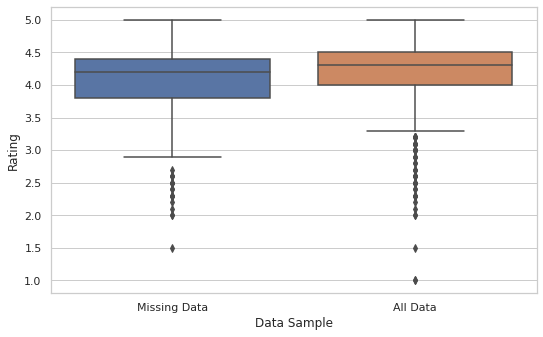

In [11]:
temp1 = sample_with_missing_data.copy()
temp1['Data Sample'] = 'Missing Data'
temp2 = sample.copy()
temp2['Data Sample'] = 'All Data'
df_to_plot = pd.concat([temp1, temp2])
sns.set_theme(style="whitegrid")
sns.boxplot(x='Data Sample', y = 'Rating', data=df_to_plot)
plt.show()

<div dir=rtl>
<h4>
4.
<br>
א. נבצע רגרסיה לינארית על סמך הנתונים השלמים בלבד:
</h4>
</div>

In [12]:
comp_data = sample_with_missing_data.dropna()
reg = LinearRegression()
reg.fit(comp_data[['Recntly Updated', 'Installs', 'IsFree',  'Reviews']], comp_data['Rating'])
print('The Coefficient Are:')
beta_cova = [reg.intercept_] + list(reg.coef_)

print(tabulate([['Coefficient'] + list([round(x, 2) for x in beta_cova])], headers=[' ', 'Bias', 'Recntly Updated', 'Installs', 'IsFree',  'Reviews']))

The Coefficient Are:
               Bias    Recntly Updated    Installs    IsFree    Reviews
-----------  ------  -----------------  ----------  --------  ---------
Coefficient    4.22               0.07       -0.22     -0.13       0.31


<div dir=rtl>
<h4>
נשים לב כי ערך ה - Bias קטן יותר מהערך שהתקבל כאשר ביצענו רגרסיה על כל הנתונים. הסיבה לכך היא שמחיקת הנתונים עם הסתברות גבוהה יותר עבור ערכים גבוהים גרמה לכך שתוחלת ה - Rating קטנה.
</h4>
</div>

In [13]:
y = comp_data['Rating'].to_numpy()
y_cova = reg.predict(comp_data[['Recntly Updated', 'Installs', 'IsFree',  'Reviews']])

x_vals = comp_data[['Recntly Updated', 'Installs', 'IsFree',  'Reviews']].to_numpy()
x_vals = np.c_[np.ones(len(x_vals)), x_vals] 
c = np.dot(x_vals.T, x_vals)
c = np.linalg.pinv(c)

eps_sigma =  sum([x**2 for x in y - y_cova])/(len(y))

parm_list = ['Bias', 'Recntly Updated', 'Installs', 'IsFree',  'Reviews']
i = 0
for b in beta_cova:
  conf_intervals[parm_list[i]].append((b - norm.ppf(0.975, 0, 1)*eps_sigma*c[i][i], b + norm.ppf(0.975, 0, 1)*eps_sigma*c[i][i]))
  print('Confidence Interval For The ', '"', parm_list[i], '"', 'Coefficient ', ': [', b - norm.ppf(0.975, 0, 1)*eps_sigma*c[i][i], ', ',  b + norm.ppf(0.975, 0, 1)*eps_sigma*c[i][i], ']')
  i += 1

Confidence Interval For The  " Bias " Coefficient  : [ 4.194075351238382 ,  4.248437719094774 ]
Confidence Interval For The  " Recntly Updated " Coefficient  : [ 0.065423441761677 ,  0.07380109260682063 ]
Confidence Interval For The  " Installs " Coefficient  : [ -0.22243050036187376 ,  -0.2133895938065775 ]
Confidence Interval For The  " IsFree " Coefficient  : [ -0.14565716261779124 ,  -0.10587947586356757 ]
Confidence Interval For The  " Reviews " Coefficient  : [ 0.30709906719111885 ,  0.31566510263700115 ]


<div dir=rtl>
<h4>
קיבלנו אורכי רווחי סמך מעט גדולים יותר (אך עדיין קטנים). סיבה אפשרית לכך היא שכעט השתמשנו בהרבה בפחות נתונים (ובפרט השונות גדלה) ולכן קיבלו רווחי סמך יותר גדולים.
</h4>
</div>

<div dir=rtl>
<h4>
4.
<br>
ב. נשלים את הנתונים החסרים באמצעות regression imputation ונבצע רגרסיה לינארית:
</h4>
</div>

In [28]:
comp_data = sample_with_missing_data.dropna()
reg_imp_df = sample_with_missing_data.copy()
reg = LinearRegression()
reg.fit(comp_data[['Recntly Updated', 'Installs', 'IsFree',  'Reviews']], comp_data['Rating'])

reg_imp_df.loc[sample_with_missing_data['Rating'].isnull(), 'Rating'] = reg.predict(sample_with_missing_data[sample_with_missing_data['Rating'].isnull()][['Recntly Updated', 'Installs', 'IsFree',  'Reviews']])

reg = LinearRegression()
reg.fit(reg_imp_df[['Recntly Updated', 'Installs', 'IsFree',  'Reviews']], reg_imp_df['Rating'])

print('The Coefficient Are:')
beta_cova = [reg.intercept_] + list(reg.coef_)

print(tabulate([['Coefficient'] + list([round(x, 2) for x in beta_cova])], headers=[' ', 'Bias', 'Recntly Updated', 'Installs', 'IsFree',  'Reviews']))


The Coefficient Are:
               Bias    Recntly Updated    Installs    IsFree    Reviews
-----------  ------  -----------------  ----------  --------  ---------
Coefficient    4.22               0.07       -0.22     -0.13       0.31


<div dir=rtl>
<h4>
המקדמים שקיבלנו לאחר השלמת הנתונים באמצעות regression imputation זהים למקדמים שקיבלנו כאשר בצענו רגרסיה אך ורק לפי הנתונים השלמים. הסיבה לכך היא "שביצענו רגרסיה על מנת לבצע רגרסיה", כלומר השלמנו את הנתונים החסרים באמצעות רגרסיה ולכן כאשר התאמנו מודל רגרסיה עבור כל הנתונים (כולל הנתונים שהשלמנו) המודל שמתאים לנתונים השלמים מתאים בצורה מדויקת לנתונים שהשלמנו (הנתונים שהשלמנו "באמת" באים מהמודל הלינארי שמצאנו) ואין צורך לשנותו.
</h4>
</div>

In [29]:
y = reg_imp_df['Rating'].to_numpy()
y_cova = reg.predict(reg_imp_df[['Recntly Updated', 'Installs', 'IsFree',  'Reviews']])

x_vals = reg_imp_df[['Recntly Updated', 'Installs', 'IsFree',  'Reviews']].to_numpy()
x_vals = np.c_[np.ones(len(x_vals)), x_vals] 
c = np.dot(x_vals.T, x_vals)
c = np.linalg.pinv(c)

eps_sigma =  sum([x**2 for x in y - y_cova])/(len(y))

parm_list = ['Bias', 'Recntly Updated', 'Installs', 'IsFree',  'Reviews']
i = 0
for b in beta_cova:
  conf_intervals[parm_list[i]].append((b - norm.ppf(0.975, 0, 1)*eps_sigma*c[i][i], b + norm.ppf(0.975, 0, 1)*eps_sigma*c[i][i]))
  print('Confidence Interval For The ', '"', parm_list[i], '"', 'Coefficient ', ': [', b - norm.ppf(0.975, 0, 1)*eps_sigma*c[i][i], ', ',  b + norm.ppf(0.975, 0, 1)*eps_sigma*c[i][i], ']')
  i += 1

Confidence Interval For The  " Bias " Coefficient  : [ 4.215206112705456 ,  4.2273069576277 ]
Confidence Interval For The  " Recntly Updated " Coefficient  : [ 0.06856478458066514 ,  0.0706597497878334 ]
Confidence Interval For The  " Installs " Coefficient  : [ -0.21897940103188476 ,  -0.21684069313656626 ]
Confidence Interval For The  " IsFree " Coefficient  : [ -0.13042466318467325 ,  -0.12111197529668537 ]
Confidence Interval For The  " Reviews " Coefficient  : [ 0.3103434927142243 ,  0.31242067711389515 ]


<div dir=rtl>
<h4>
רווחי הסמך שקיבלנו קטנים משמעותית מרווחי הסמך שקיבלנו כאשר בצענו רגרסיה רק על הנתונים השלמים (בין 0.006 ל - 0.02). הסיבה לכך היא ש - 500 מתוך הרשומות בסט הנתונים "באמת" הגיעו מהמודל הלינארי שמצאנו (כפי שציינו קודם) ולכן המודל "יותר בטוח בעצמו".
</h4>
</div>

<div dir=rtl>
<h4>
4.
<br>
ג. נשלים את הנתונים החסרים באמצעות multiple imputation ונבצע רגרסיה לינארית:
</h4>
</div>

In [16]:
comp_data = sample_with_missing_data.dropna()
reg = LinearRegression()
reg.fit(comp_data[['Recntly Updated', 'Installs', 'IsFree',  'Reviews']], comp_data['Rating'])

sigma = 1
M = 1000
y_reg = reg.predict(sample_with_missing_data[sample_with_missing_data['Rating'].isnull()][['Recntly Updated', 'Installs', 'IsFree',  'Reviews']])
vars = [0, 0, 0, 0, 0]
beta_M = []
for m in range(M):
  reg_imp_df = sample_with_missing_data.copy()
  y_m = []
  for i in range(len(y_reg)):
    y_m.append(np.random.normal(y_reg[i], sigma, 1)[0])

  reg_imp_df.loc[sample_with_missing_data['Rating'].isnull(), 'Rating'] = y_m
  reg = LinearRegression()
  reg.fit(reg_imp_df[['Recntly Updated', 'Installs', 'IsFree',  'Reviews']], reg_imp_df['Rating'])
  beta_M.append([reg.intercept_] + list(reg.coef_))

  y = reg_imp_df['Rating'].to_numpy()
  y_cova = reg.predict(reg_imp_df[['Recntly Updated', 'Installs', 'IsFree',  'Reviews']])
  x_vals = reg_imp_df[['Recntly Updated', 'Installs', 'IsFree',  'Reviews']].to_numpy()
  x_vals = np.c_[np.ones(len(x_vals)), x_vals]
  c = np.dot(x_vals.T, x_vals)
  c = np.linalg.pinv(c)
  eps_sigma =  sum([x**2 for x in y - y_cova])/(len(y))
  for i in range(len(beta_M[0])):
    vars[i] += eps_sigma*c[i][i]

beta_M = np.array(beta_M).T
beta_cova = [np.mean(beta_M[0]), np.mean(beta_M[1]), np.mean(beta_M[2]), np.mean(beta_M[3]), np.mean(beta_M[4])]


print('The Coefficient Are:')
print(tabulate([['Coefficient'] + list([round(x, 2) for x in beta_cova])], headers=[' ', 'Bias', 'Recntly Updated', 'Installs', 'IsFree',  'Reviews']))

The Coefficient Are:
               Bias    Recntly Updated    Installs    IsFree    Reviews
-----------  ------  -----------------  ----------  --------  ---------
Coefficient    4.22               0.07       -0.22     -0.13       0.31


<div dir=rtl>
<h4>
בהרצאה ראינו כי האומדים המתקבלים כאשר משתמשים ב - multiple imputation זהים לאומדים המתקבלים מ - regression imputation, ואכן קיבלנו מקדמי רגרסיה זהים  לאלו שקיבלנו קודם.
</h4>
</div>

<div dir=rtl>
<h4>
4.
<br>
ד. נשתמש באומד של רובין ונחשב רווחי סמך:
</h4>
</div>

In [17]:
parm_list = ['Bias', 'Recntly Updated', 'Installs', 'IsFree',  'Reviews']
i = 0
for b in beta_cova:
  vars[i] /= M
  vars[i] += ((M + 1)/(M*(M - 1)))*sum([x**2 for x in beta_M[i] - b])
  conf_intervals[parm_list[i]].append((b - norm.ppf(0.975, 0, 1)*vars[i], b + norm.ppf(0.975, 0, 1)*vars[i]))
  print('Confidence Interval For The ', '"', parm_list[i], '"', 'Coefficient ', ': [', b - norm.ppf(0.975, 0, 1)*vars[i], ', ',  b + norm.ppf(0.975, 0, 1)*vars[i], ']')
  i += 1

Confidence Interval For The  " Bias " Coefficient  : [ 4.153906223276284 ,  4.2804599806212185 ]
Confidence Interval For The  " Recntly Updated " Coefficient  : [ 0.059319153913024864 ,  0.07985372097418036 ]
Confidence Interval For The  " Installs " Coefficient  : [ -0.22588075011730993 ,  -0.20507229701754728 ]
Confidence Interval For The  " IsFree " Coefficient  : [ -0.1731321399859038 ,  -0.08203562484872143 ]
Confidence Interval For The  " Reviews " Coefficient  : [ 0.2994595521174938 ,  0.31929963884438645 ]


<div dir=rtl>
<h4>
כצפוי,
אורכי רווחי הסמך שקיבלנו גדולים יותר מאורכי רווחי הסמך שקיבלנו כאשר השלמנו באמצאות regrassion imputation שכן שיטת multiple imputation  מגדילה את השונות.
</h4>
</div>

<div dir=rtl>
<h4>
4.
<br>
ה. נשתמש ברגרסיה לוגיסטית על מנת לחשב את $P(R = 1|X_1,...X_k)$:
</h4>
</div>

In [18]:
sample_with_missing_data['R'] = sample_with_missing_data.Rating.apply(lambda x: 1 if not math.isnan(x) else 0)

log_reg = LogisticRegression()
log_reg.fit(sample_with_missing_data[['Recntly Updated', 'Installs', 'IsFree',  'Reviews']], sample_with_missing_data['R'])

proba = log_reg.predict_proba(comp_data[['Recntly Updated', 'Installs', 'IsFree', 'Reviews']]).T[0]

<div dir=rtl>
<h4>
4.
<br>
ו. נמצא אומד PWI למקדמי הרגרסיה:
</br>
נסמן ב - $X_i$ את המשתנים המסבירים ברשומה ה - i ונסמן $\hatπ(X_i) ≡ \hat{P}(R = 1|X_{i,1},...,X_{i,k})$.
</br>

<br>
אומד PWI ל - $β$ יהיה:
<br>  
</h4>
<h2>
\begin{align}
\hatβ = arg\min_{β} \sum_{i=1}^n\frac{R_i}{\hatπ(X_i)}\cdot (X_i^T\beta - Y_i)^2 = 
arg\min_{β} \sum_{i:not\space missing}\left( \frac{X_i^T\beta - Y_i}{\sqrt{\hatπ(X_i)}}\right)^2
\end{align}
</h2>
<h4>
</br>
נסמן : $\tilde{Y} =\begin{pmatrix}
           \frac{Y_{1}}{\sqrt{\hatπ(X_1)}} \\
           \frac{Y_{2}}{\sqrt{\hatπ(X_2)}} \\
           \vdots \\
           \frac{Y_{n}}{\sqrt{\hatπ(X_n)}}
         \end{pmatrix}
,  
\tilde{X} =\begin{pmatrix}
           -\frac{X_{1}^T}{\sqrt{\hatπ(X_1)}}- \\
           -\frac{X_{2}^T}{\sqrt{\hatπ(X_2)}}-\\
           \vdots \\
           -\frac{X_{n}^T}{\sqrt{\hatπ(X_n)}}-
         \end{pmatrix}$   
ונקבל:
<h2>
\begin{align}
\hatβ = arg\min_{β} ||\tilde{X}β - \tilde{Y}||^2_2
\end{align}
</h2>    
</h4>
</div>

<div dir=rtl>
<h4>
מקדמי הרגירסיה הם:
</h4>
</div>

In [19]:
x_mat = comp_data[['Recntly Updated', 'Installs', 'IsFree', 'Reviews']].to_numpy()
x_mat = np.c_[np.ones(len(x_mat)), x_mat]
y = comp_data['Rating'].to_numpy()

x_mat = np.array([1/np.sqrt(proba[i]) * x_mat[i] for i in range(len(x_mat))])
y = np.array([1/np.sqrt(proba[i]) * y[i] for i in range(len(x_mat))])

beta_ipw = np.linalg.inv(x_mat.T@x_mat) @ x_mat.T@y

print('The Coefficient Are:')
print(tabulate([['Coefficient'] + list([round(x, 2) for x in beta_ipw])], headers=[' ', 'Bias', 'Recntly Updated', 'Installs', 'IsFree',  'Reviews']))

The Coefficient Are:
               Bias    Recntly Updated    Installs    IsFree    Reviews
-----------  ------  -----------------  ----------  --------  ---------
Coefficient    4.22               0.07        -0.2     -0.16        0.3


<div dir=rtl>
<h4>
קיבלנו מקדמי רגרסיה דומים למקדמים שקיבלנו בסיעיפים הקודמים.
</h4>
</div>

<div dir=rtl>
<h4>
4.
<br>
ז. נמצא רווחי סמך למקדמים באמצעות בוטסראפ:
</h4>
</div>

In [20]:
B = 500
M = 100
betas_bootstrap = [[] for _ in range(5)]
for i in range(B):
    sample_all = comp_data.sample(M, replace = True).reset_index(inplace = False)
    sample_x = sample_all[['Recntly Updated', 'Installs', 'IsFree', 'Reviews']].to_numpy()
    sample_x = np.c_[np.ones(len(sample_x)), sample_x]
    sample_y = sample_all['Rating'].to_numpy()
    
    sample_x = np.array([1/np.sqrt(proba[i]) * sample_x[i] for i in range(len(sample_x))])
    sample_y = np.array([1/np.sqrt(proba[i]) * sample_y[i] for i in range(len(sample_x))])
    curr_beta_ipw = np.linalg.pinv(sample_x.T@sample_x) @ sample_x.T@sample_y

    for i in range(len(curr_beta_ipw)):
        betas_bootstrap[i].append(curr_beta_ipw[i])
vars = []
for i in range(5):
    vars.append(np.var(np.array(betas_bootstrap[i])))
for i,b in enumerate(beta_ipw):
  conf_intervals[parm_list[i]].append((b - norm.ppf(0.975, 0, 1)*vars[i],b + norm.ppf(0.975, 0, 1)*vars[i]))
  print('Confidence Interval For Coefficient Number ', i, ': [', b - norm.ppf(0.975, 0, 1)*vars[i], ', ',  b + norm.ppf(0.975, 0, 1)*vars[i], ']')


Confidence Interval For Coefficient Number  0 : [ 3.9256337797077583 ,  4.508520220632662 ]
Confidence Interval For Coefficient Number  1 : [ 0.048702208993783414 ,  0.09139509266079715 ]
Confidence Interval For Coefficient Number  2 : [ -0.24726265717244358 ,  -0.16098921638512473 ]
Confidence Interval For Coefficient Number  3 : [ -0.3321905611741665 ,  0.016462627124625484 ]
Confidence Interval For Coefficient Number  4 : [ 0.2670216689982886 ,  0.33381898845046376 ]


<div dir=rtl>
<h4>
בניגוד לסעיפים הקודמים, רווחי הסמך שקיבלנו הם יחסית ארוכים (ואף חלקם מכילים את האומד שהתקבל מהרגרסיה על כל הנתונים). אנו משערים שתוצאה זו נובעת מהשיטה לבניית רווחי הסמך, בוטסטראפ, "שמכניסה" יותר שונות.
</h4>
</div>

<div dir=rtl>
<h4>
4.
<br>
ח. לכל מקדם, נציג את רווחי הסמך שהתקבלו מכל שיטה:
</h4>
</div>

In [21]:
def plot_ci(parm, color):
  plt.yticks(np.arange(5), ['All Data', 'Only Complete Data', 'Regression Imputation', 'Mulitple Imputation', 'IPW'])
  i = 0
  for c in conf_intervals[parm]: 
    plt.plot(c, [i, i], linewidth=10, color=color, alpha =0.8)
    plt.scatter([c[0]/2 + c[1]/2], [i], color='black', linewidths=0.01)
    i += 1
  plt.title('CI For Confidence "' + parm + '"')
  plt.show()

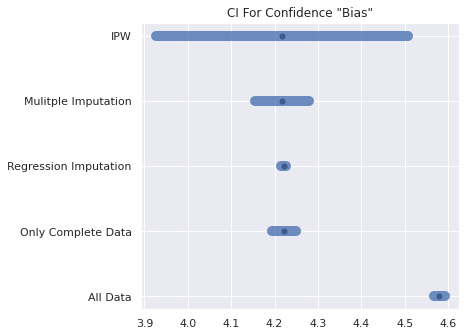

In [22]:
sns.set(rc={'figure.figsize':(5.7,5.27)})

color_list = ['b', 'r', 'y', 'g', 'pink']
j = 0

plot_ci(parm_list[j], color_list[j])
j += 1

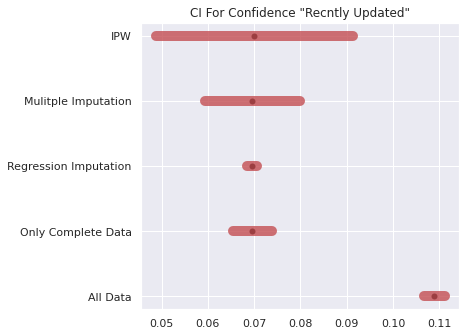

In [23]:
sns.set(rc={'figure.figsize':(5.7,5.27)})

plot_ci(parm_list[j], color_list[j])
j += 1

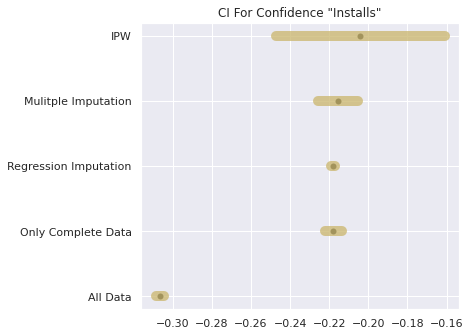

In [24]:
sns.set(rc={'figure.figsize':(5.7,5.27)})

plot_ci(parm_list[j], color_list[j])
j += 1

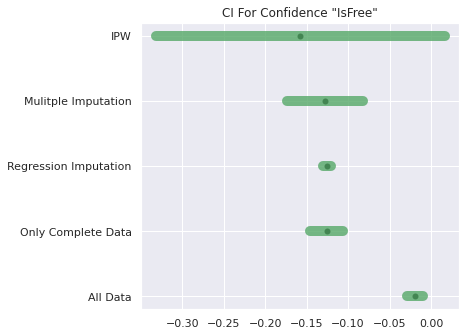

In [25]:
sns.set(rc={'figure.figsize':(5.7,5.27)})

plot_ci(parm_list[j], color_list[j])
j += 1

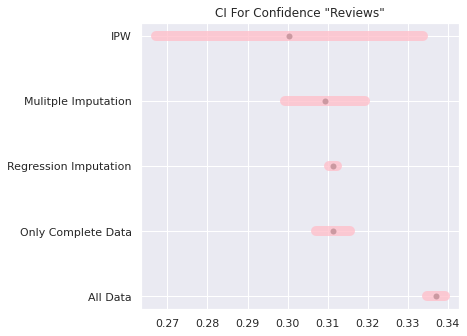

In [26]:
sns.set(rc={'figure.figsize':(5.7,5.27)})

plot_ci(parm_list[j], color_list[j])
j += 1

<div dir=rtl>
<h4>
 נשים לב כי באופן כללי ערכי האומדים המתקבלים דומים בכל שיטות השלמת הנתונים. בהשוואה  לערכים המתקבלים משאלה 2 (שהתבססו על כל המידע). הערכים מעט רחוקים מהערך האמיתי (מרחק שנע בין - 0.2 ל - 0.5 יחידות). לכן, נסיק כי בעוד שהשיטות לא מצליחות לתפוס את הנתונים החסרים.
</br>
הסבר אפשרי לכישלון השיטות הוא שהנתונים שהחסרנו הם אינם missing at random, אלא missing not at random ולכן השיטות להשלמת הנתונים (המסתמכים על הנחת MAR) נכשלות. משמעות הסבר זה היא שאין קשר משמעותי בין המשתנה המוסבר למשתנים המסבירים, אפשרות מעט פחות סבירה שכן מתוצאות שקיבלנו בחלקים קודמים של הפרוייקט מצאנו קשר כזה.
</br>
אפשרות נוספת היא שאין מספיק רשומות "שהיינו אמורים למחוק" בסט הנתונים ולכן לא מצאנו את הקשר שמסביר גם את הנתונים החסרים.
</div>

<div dir=rtl>
<h4>
נציג גרף המתאר את אורכי רווחי הסמך כתלות בשיטת השלמת הנתונים:
</h4>
</div>

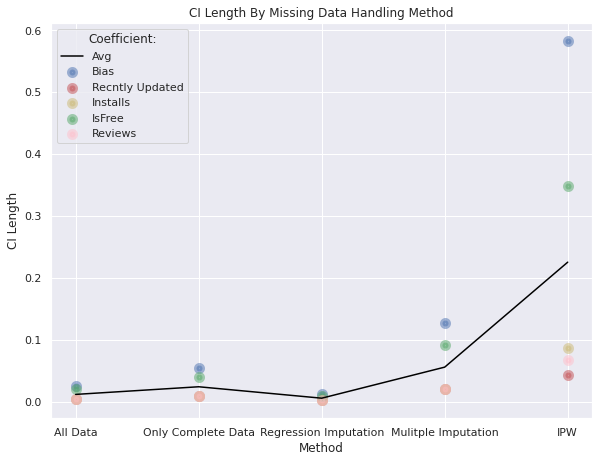

In [27]:
sns.set(rc={'figure.figsize':(9.7,7.27)})

color_list = ['b', 'r', 'y', 'g', 'pink']
m_list = ['All Data', 'Only Complete Data', 'Regression Imputation', 'Mulitple Imputation', 'IPW']
j = 0
for parm in parm_list:
  color = color_list[j]
  plt.xticks(np.arange(5), m_list)
  i = 0
  for c in conf_intervals[parm]: 
    if i == 0:
      plt.scatter([i], [c[1] - c[0]], color=color, linewidths=5, alpha=0.5, label=parm)
    else:   
      plt.scatter([i], [c[1] - c[0]], color=color, linewidths=5, alpha=0.5)
    i += 1
  j += 1  

plt.plot(range(len(parm_list)), [np.mean([conf_intervals[parm][m][1] - conf_intervals[parm][m][0] for parm in parm_list])\
                                 for m in range(len(m_list))], color='black', label='Avg')

plt.title('CI Length By Missing Data Handling Method')
plt.xlabel('Method')  
plt.ylabel('CI Length')  
plt.legend(title="Coefficient:")
plt.show()

<div dir=rtl>
<h4>
בגרף, ניתן לראות בצורה טובה את התופעות שמצאנו קודם:
<br>
1. ללא נתונים חסרים - רווחי סמך קצרים הנובעים משונות נמוכה בנתונים.
</br>
2. רק נתונים שלמים - רווחי סמך מעט יותר רחבים הנובעים ממספר קטן יותר של רשומות.
</br>
3. השלמת נתונים חסרים באמצעות regression imputation - רווחי סמך מאוד קצרים בנובעים מכך ש - 50% מהרשומות באמת נוצרו מהמודל הלינארי שמצאנו.
</br>
4. השלמת נתונים חסרים באמצעות multiple imputation - קיבלנו רווחי סמך רחבים יותר. זאת מפני שמטרת השלמה זו היא להגדיל את השונות ביחס לregression imputation והיא השלימה את מטרתה בהצלחה.
</br>
5. השלמת נתונים חסרים באמצעות IPW - אורכי רווחי הסמך ארוכים יחסית לשאר רווחי הסמך, הבדל שכנראה נובע משיטת בניית רווח הסמך (בוטסטרפ).
</h4>
</div>